# Простая карта России на Python

В этом коротком примере я показываю, как можно построить простую карту России с использованием различных библиотек языка `Python`.

## Загрузка пакетов

Для начала установим и загрузим пакеты, необходимые для пространственного анализа. 

In [1]:
# Стандартные пакеты для обработки и визуализации
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Пакеты для пространственного анализа
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pygadm

## Пространственные данные

Для осуществления пространственного анализа нам для начала нужны геоданные. Я буду использовать функцию из пакета pygadm для доступа к данным с сайта GADM: https://gadm.org/data.html. На самом сайте есть более старые и новые версии в разных форматах. Подробнее о форматах: https://gadm.org/formats.html.

Загрузим геоданные о российских регионах (для уровня регионов указываем `content_level=1`):

In [2]:
gdf = pygadm.Items(name="Russia", content_level=1)

Перейдем к другому формату, чтобы можно было использовать возможности пакета `geopandas`. При этом для дальнейшей работы важно указать Coordinate Reference System (CRS). Подробнее можно об этих системах можно почитать по [ссылке](https://automating-gis-processes.github.io/CSC/notebooks/L2/projections.html).

In [3]:
gdf = gpd.GeoDataFrame(gdf, geometry=gdf.geometry, crs='epsg:4326')

In [4]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Теперь мы работаем с набором данных, в котором содержатся различные пространственные данные. Колонки `NAME_1`, `NL_NAME_1` содержат названия регионов на латинице и на русском соответственно. И те, и другие не совсем соответствуют официальным названиям регионов РФ, но что-то нам нужно будет использовать для объединения с экономическими данными по регионам. Я для этого возьму колонку `NAME_1` для воспроизводимости в международном контексте и лучшей читаемости иностранными коллегами.

Колонка `geometry` содержит координаты для построения мультиполигонов. Эти данные позволяют строить карты.

In [5]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   83 non-null     geometry
 1   GID_1      83 non-null     object  
 2   GID_0      83 non-null     object  
 3   NAME_0     83 non-null     object  
 4   NAME_1     83 non-null     object  
 5   VARNAME_1  83 non-null     object  
 6   NL_NAME_1  83 non-null     object  
 7   TYPE_1     83 non-null     object  
 8   ENGTYPE_1  83 non-null     object  
 9   CC_1       83 non-null     object  
 10  HASC_1     83 non-null     object  
 11  ISO_1      83 non-null     object  
dtypes: geometry(1), object(11)
memory usage: 7.9+ KB


In [6]:
gdf.head()

,geometry,GID_1,GID_0,NAME_0,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
0,"MULTIPOLYGON (((40.38720 44.67210, 40.37500 44...",RUS.1_1,RUS,Russia,Adygey,Adygea|Adygeya|Adygheya|Republic,РеспубликаАдыгея,Respublika,Republic,NA,RU.AD,NA
1,"MULTIPOLYGON (((82.74660 50.94900, 82.73070 50...",RUS.2_1,RUS,Russia,Altay,AltayskiyKray,Алтайскийкрай,Kray,Territory,NA,RU.AL,NA
2,"MULTIPOLYGON (((130.50300 48.85650, 130.48850 ...",RUS.3_1,RUS,Russia,Amur,AmurskayaOblast,Амурскаяобласть,Oblast,Region,NA,RU.AM,NA
3,"MULTIPOLYGON (((44.51250 60.93200, 44.30580 60...",RUS.4_1,RUS,Russia,Arkhangel'sk,Arcangelo|Archangel|Archangelsk|,Архангельскаяобласть,Oblast,Region,NA,RU.AR,NA
4,"MULTIPOLYGON (((47.87490 45.56920, 47.84980 45...",RUS.5_1,RUS,Russia,Astrakhan',Astrachan|AstrakhanskayaOblast,Астраханскаяобласть,Oblast,Region,NA,RU.AS,NA


Из-за расположения территории России в двух полушариях карта выглядит не очень корректно:

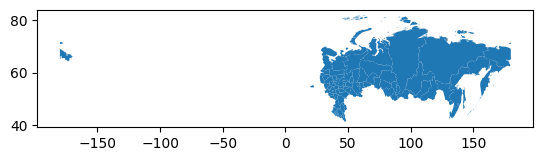

In [7]:
gdf.plot()
plt.show()

Исправим проблему с координатной системой:

In [8]:
gdf = gdf.to_crs('+proj=longlat +lon_wrap=180')

Теперь получается адекватная карта:

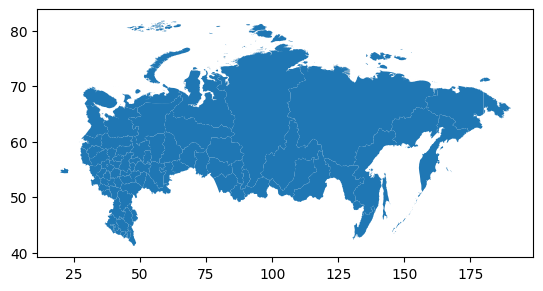

In [9]:
gdf.plot()
plt.show()

## Экономические данные

Теперь загрузим какие-нибудь данные о российских регионах. Для примера возьмем данные о численности населения. Как можно видеть, для дальнейшей совместимости в пространственными данными, названия регионов здесь указаны так же, как в наборе пространственных данных. 

In [10]:
rus_reg_pop = pd.read_csv('rus_reg_pop.csv')
rus_reg_pop.head()

,region,population
0,Altay,2380.8
1,Amur,807.8
2,Arkhangel'sk,1135.1
3,Astrakhan',1020.0
4,Belgorod,1549.0


Объединим экономические данные с геопространственными:

In [11]:
rus_reg_full = gdf.merge(rus_reg_pop, how='left', left_on='NAME_1', right_on='region')
rus_reg_full.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    83 non-null     geometry
 1   GID_1       83 non-null     object  
 2   GID_0       83 non-null     object  
 3   NAME_0      83 non-null     object  
 4   NAME_1      83 non-null     object  
 5   VARNAME_1   83 non-null     object  
 6   NL_NAME_1   83 non-null     object  
 7   TYPE_1      83 non-null     object  
 8   ENGTYPE_1   83 non-null     object  
 9   CC_1        83 non-null     object  
 10  HASC_1      83 non-null     object  
 11  ISO_1       83 non-null     object  
 12  region      82 non-null     object  
 13  population  82 non-null     float64 
dtypes: float64(1), geometry(1), object(12)
memory usage: 9.2+ KB


## Карта

Теперь построим карту. 

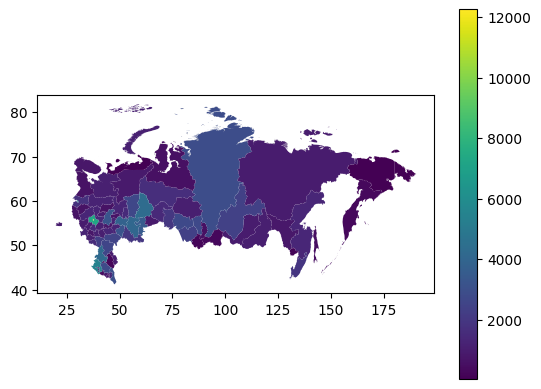

In [12]:
rus_reg_full.plot(column='population', legend=True)
plt.show()

Карту можно немного понастраивать. 

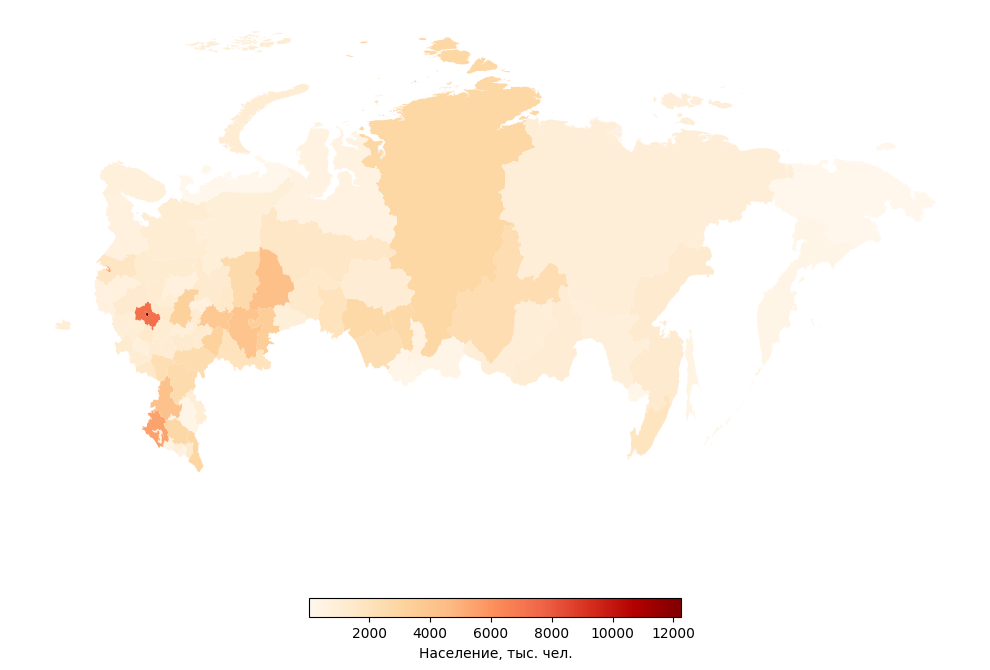

In [13]:
fig, ax = plt.subplots(1, figsize=(16, 9))

ax.axis('off')

rus_reg_full.plot(
    column='population', 
    cmap='OrRd', 
    legend=True,
    legend_kwds={"label": "Население, тыс. чел.", "orientation": "horizontal", 'shrink': 0.3},
    ax=ax
)

plt.show()

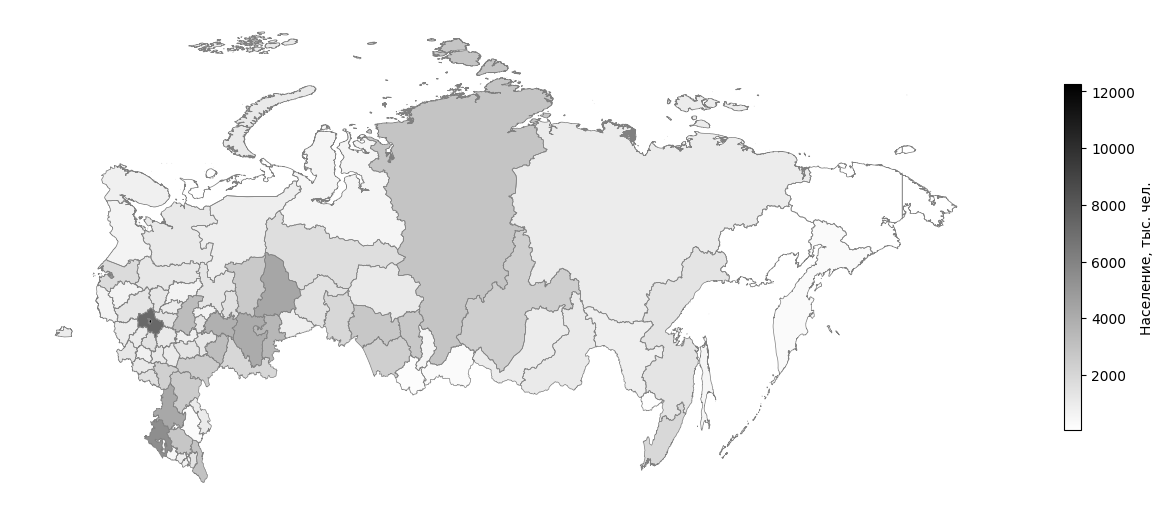

In [14]:
fig, ax = plt.subplots(1, figsize=(16, 9))

ax.axis('off')

rus_reg_full.boundary.plot(color='grey', linewidth=0.5, ax=ax)

rus_reg_full.plot(column='population',
                  cmap='gist_yarg', 
                  legend=True, 
                  legend_kwds={"label": "Население, тыс. чел.", 'shrink': 0.5},
                  ax=ax)

plt.show()

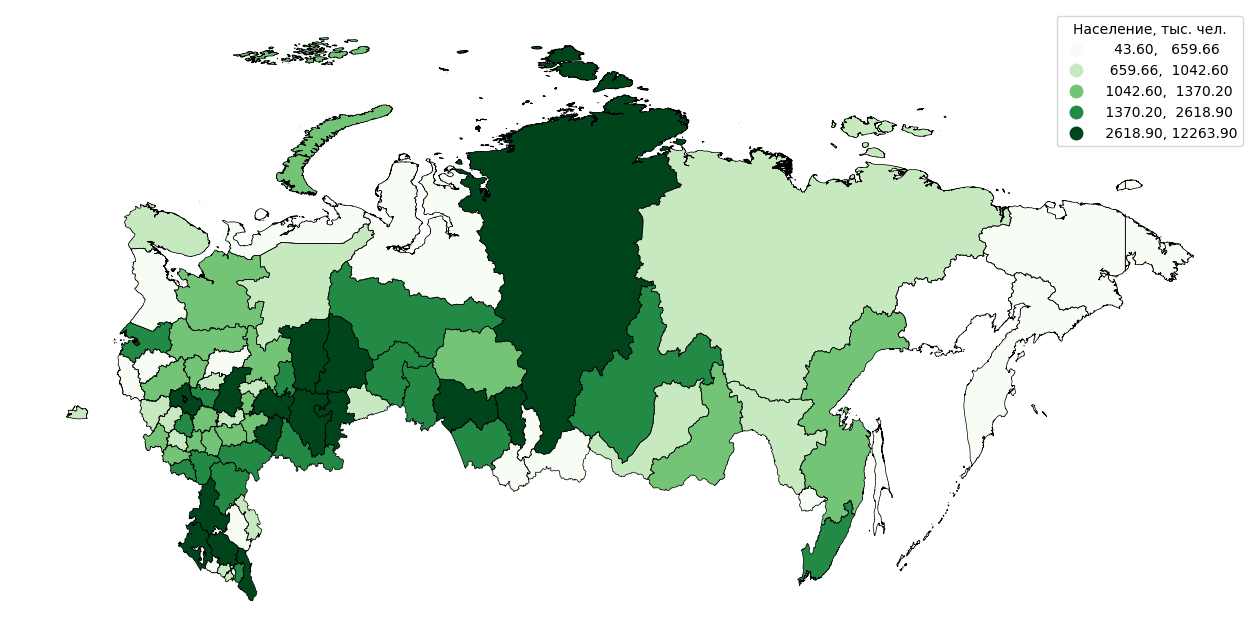

In [15]:
fig, ax = plt.subplots(1, figsize=(16, 9))

ax.axis('off')

rus_reg_full.boundary.plot(color='black', linewidth=0.5, ax=ax)

rus_reg_full.plot(
    column='population', 
    cmap='Greens',
    scheme='quantiles',
    legend=True,
    ax=ax
)

leg = ax.get_legend()
leg.set_title("Население, тыс. чел.")

plt.show()